In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#tests precip sensitivity to TC distance

In [ ]:
ds6=xr.open_dataset(dir+'IBTrACS.NA.v04r00.nc')
lat_tc=ds6.lat.values.flatten().tolist()
lon_tc=ds6.lon.values.flatten().tolist()
ds7=xr.open_dataset(dir+'ibtracs_na_time.nc')
years_tc=ds7.years.values.flatten().tolist()
months_tc=ds7.months.values.flatten().tolist()
days_tc=ds7.days.values.flatten().tolist()
hours_tc=ds7.hours.values.flatten().tolist()
nature_tc=ds7.nature.values.flatten().tolist()#1 if tropical, 0 if not
zipped_dates=list(zip(years_tc,months_tc,days_tc,hours_tc,nature_tc,lat_tc,lon_tc))

tropical_dates=[x for x in zipped_dates if x[4]==1]
tropical_datetimes=[dt.datetime(int(x[0]),int(x[1]),int(x[2]),int(x[3])) for x in tropical_times]
nontropical_dates=[x for x in zipped_dates if x[4]==0]
nontropical_datetimes=[dt.datetime(int(x[0]),int(x[1]),int(x[2]),int(x[3])) for x in nontropical_times]

dp=xr.open_dataset(dir+'station_numbers.nc')
print(dp)
stations=dp.stations.values.tolist()
lats=dp.lats.values.tolist()
lons=dp.lons.values.tolist()
lons=[x+360. for x in lons]
elevs=dp.elevs.values.tolist()
thresholds=dp.thresholds.values.tolist()
lats_closest_era5=dp['lats_closest_era5'].values.tolist()
lons_closest_era5=dp['lons_closest_era5'].values.tolist()
zipped_station=list(zip(lons,lats,lons_closest_era5,lats_closest_era5,thresholds))
if 1==1:#part 2: read the obs at eligible stations into a better format
    yr_start=1979
    yr_end=2019
    tuples=[]
    years=[]
    months=[]
    days1=[]
    lats1=[]
    lons1=[]
    elevs1=[]
    observations=[]
    dates=[]
    station_names_list=[]
    stations_list=[]
    station_names=dp.station_names.values.tolist()
    points=zip(lons,lats)
    for i in range(len(stations)):
        print(str(i+1)+'/'+str(len(stations)))
        lat=lats[i]
        lon=lons[i]
        elev=elevs[i]
        station_name=station_names[i]
        station=stations[i]
        filename=stations[i]
        ds1=pd.read_csv(filename,header=None)
        nancount=0
        qcount=0
        yescount=0
        for row1 in ds1.iterrows():
            row_neg_space=row1[1][0].replace('-',' -')
            row_basic=row1[1][0]
            a=row_neg_space.split()
            code=a[0][-4:]
            if code=='PRCP':
                year=int(a[0][11:15])
                if yr_start<=year<=yr_end:
                    month=int(a[0][15:17])
                    if month in [1,3,5,7,8,10,12]:
                        days=31
                    if month in [4,6,9,11]:
                        days=30
                    if month==2 and year%4==0:
                        days=29
                    if month==2 and year%4!=0:
                        days=28
                    for i in range(days):
                        #print(row_basic)
                        mflag=row_basic[26+8*i]
                        qflag=row_basic[27+8*i]
                        sflag=row_basic[28+8*i]
                        obs=float(row_basic[21+8*i:26+8*i])
                    
                        if obs==-9999.0:
                            pass
                        elif qflag!=' ':
                            pass
                        else:
                            years.append(year)
                            months.append(month)
                            days1.append(i)
                            observations.append(obs/10.)#convert from tenths of mm to mm
                            lats1.append(lat)
                            lons1.append(lon)
                            elevs1.append(elev)
                            date=dt.datetime(year,month,i+1,6)
                            dates.append(date)
                            station_names_list.append(station_name)
                            stations_list.append(station)
    percentile=99
    lats=lats1
    lons=lons1
    obs=observations
    zipped=list(zip(dates,lats,lons,obs,stations_list))
    for i in range(yr_end-yr_start+1):
        print(i)
        year=yr_start+i
        starting_date=dt.datetime(year,9,1,6)
        date_range=[starting_date+dt.timedelta(x) for x in range(91)]
        if i==0:
            all_dates=date_range
        else:
            all_dates=all_dates+date_range
            
    min_distance_list_trop=[]
    obs_list_trop=[]
    min_distance_list_nontrop=[]
    obs_list_nontrop=[]
    for i in range(len(all_dates)):#move through all days
        print(i)
        select_day=[x for x in zipped if x[0]==all_dates[i]]
        date_day=all_dates[i]
        day_range=[date_day+dt.timedelta(hours=6*x) for x in range(4)]
        for j in range(len(select_day)):
            lat_station=select_day[j][1]
            lon_station=select_day[j][2]
            obs_station=select_day[j][3]
            date=select_day[j][0]
            station=select_day[j][4]
            min_distance_trop=1e4
            min_distance_nontrop=1e4
            for k in range(4):
                date_6h=day_range[k]
                year=date_6h.year
                month=date_6h.month
                day=date_6h.day
                hour=date_6h.hour
                if date_6h in tropical_datetimes:
                    select_zip=[x for x in zipped_dates if x[0]==year and x[1]==month and x[2]==day and x[3]==hour]
                    if len(select_zip)==1:
                        print(select_zip)
                        lat_tc=select_zip[0][5]
                        lon_tc=select_zip[0][6]
                        distance=geopy.distance.distance((lat_tc,lon_tc),(lat_station,lon_station)).km
                        if distance<min_distance_trop:
                            min_distance_trop=distance
                    else:
                        for n in range(len(select_zip)):
                            lat_tc=select_zip[n][5]
                            lon_tc=select_zip[n][6]
                            distance=geopy.distance.distance((lat_tc,lon_tc),(lat_station,lon_station)).km
                            if distance<min_distance_trop:
                                min_distance_trop=distance
                                
                if date_6h in nontropical_datetimes:
                    select_zip=[x for x in zipped_dates if x[0]==year and x[1]==month and x[2]==day and x[3]==hour]
                    if len(select_zip)==1:
                        print(select_zip)
                        lat_tc=select_zip[0][5]
                        lon_tc=select_zip[0][6]
                        distance=geopy.distance.distance((lat_tc,lon_tc),(lat_station,lon_station)).km
                        if distance<min_distance_nontrop:
                            min_distance_nontrop=distance
                    else:
                        for n in range(len(select_zip)):
                            lat_tc=select_zip[n][5]
                            lon_tc=select_zip[n][6]
                            distance=geopy.distance.distance((lat_tc,lon_tc),(lat_station,lon_station)).km
                            if distance<min_distance_nontrop:
                                min_distance_nontrop=distance
            min_distance_list_trop.append(min_distance_trop)
            obs_list_trop.append(obs_station)
            min_distance_list_nontrop.append(min_distance_nontrop)
            obs_list_nontrop.append(obs_station)
print(min_distance_list_trop)

In [ ]:
fig=plt.figure(figsize=(14,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs daily rainfall
ax.scatter(min_distance_list_trop,obs_list_trop,s=1,c='r',alpha=0.1)#,label='IBTrACS TCs')
ax.scatter(min_distance_list_nontrop,obs_list_nontrop,s=1,c='k',alpha=0.1)#,label='IBTrACS non-tropical systems')

zipped_trop=list(zip(min_distance_list_trop,obs_list_trop))
zipped_nontrop=list(zip(min_distance_list_nontrop,obs_list_nontrop))
bins=np.arange(0,1500,10)
mean_trop_list=[]
mean_nontrop_list=[]
prob_50_trop_list=[]
prob_50_nontrop_list=[]
for i in range(len(bins)-1):
    print(i)
    obs_trop=[x[1] for x in zipped_trop if bins[i]<=x[0]<bins[i+1]]#trop = tropical IBTrACS system, nontrop = nontropical IBTrACS system
    mean_obs_trop=float(sum(obs_trop))/float(len(obs_trop))
    mean_trop_list.append(mean_obs_trop)
    
    obs_nontrop=[x[1] for x in zipped_nontrop if bins[i]<=x[0]<bins[i+1]]
    mean_obs_nontrop=float(sum(obs_nontrop))/float(len(obs_nontrop))
    mean_nontrop_list.append(mean_obs_nontrop)
    
    obs_trop_50=[x[1] for x in zipped_trop if bins[i]<=x[0]<bins[i+1] and x[1]>=50]
    percent_50_trop=float(len(obs_trop_50))/float(len(obs_trop))
    prob_50_trop_list.append(percent_50_trop)
    
    obs_nontrop_50=[x[1] for x in zipped_nontrop if bins[i]<=x[0]<bins[i+1] and x[1]>=50]
    percent_50_nontrop=float(len(obs_nontrop_50))/float(len(obs_nontrop))
    prob_50_nontrop_list.append(percent_50_nontrop)

ax.plot([x+5 for x in bins[:-1]],mean_trop_list,color='r',linewidth=3.0,label='IBTrACS TCs')
ax.plot([x+5 for x in bins[:-1]],mean_nontrop_list,color='k',linewidth=3.0,label='IBTrACS non-tropical systems')
ax.tick_params(labelsize=19)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from station (km)',fontsize=19)
ax.set_ylabel('Daily precipitation (mm)',fontsize=19)
ax.set_xlim(0,1500)
ax.set_ylim(0,100)
ax.set_title('TC Proximity vs Daily Precipitation',fontsize=26)
plt.legend(loc='upper right',fontsize=17)
plt.show()

In [47]:
fig.savefig(dir+'neusa_tc_proximity_test_1.png')

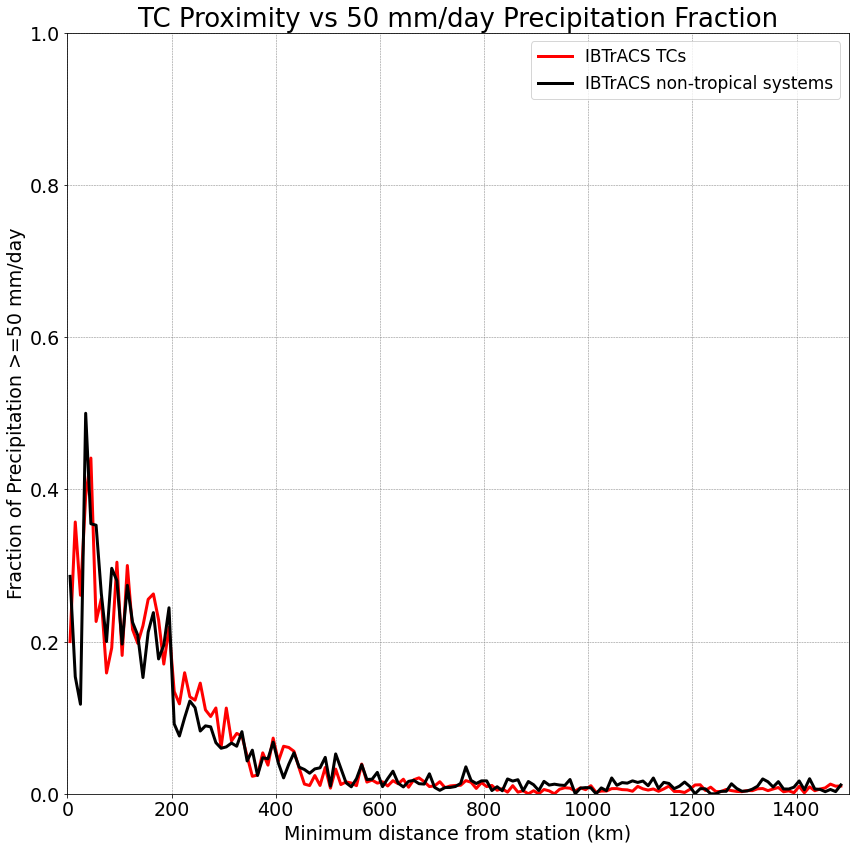

In [49]:
fig=plt.figure(figsize=(14,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs probability of >=50 mm/day precipitation
ax.plot([x+5 for x in bins[:-1]],prob_50_trop_list,color='r',linewidth=3.0,label='IBTrACS TCs')
ax.plot([x+5 for x in bins[:-1]],prob_50_nontrop_list,color='k',linewidth=3.0,label='IBTrACS non-tropical systems')
ax.tick_params(labelsize=19)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from station (km)',fontsize=19)
ax.set_ylabel('Fraction of Precipitation >=50 mm/day',fontsize=19)
ax.set_xlim(0,1500)
ax.set_ylim(0,1)
ax.set_title('TC Proximity vs 50 mm/day Precipitation Fraction',fontsize=26)
plt.legend(loc='upper right',fontsize=17)
plt.show()

In [50]:
fig.savefig(dir+'neusa_tc_proximity_test_2.png')